<a href="https://colab.research.google.com/github/kalpathy/rsna_MONAI/blob/main/RSNA_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Environment**

Make sure you are using a GPU for this notebook. From the dropdown menu, select "Runtime" and then "Change Runtime Type". Make sure that GPU is selected under the "Hardware Accelerator" option.

In [ ]:
#Load in MONAI package

!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

# **Setup Imports**

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    Flip,
    Rotate,
    Zoom,
    RandGaussianNoise,
    Rand2DElastic
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.8.dev2146
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 581f3c68cc30b2b8b12c5bc31b56b6922f9d7a54

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Check to see if you are using a GPU. If the following block outputs "False", then you are not using GPU resources (which will result in very slow neural network training.

In [ ]:
print(torch.cuda.is_available())

True


# **Setup data directory**

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp06iffjjl


# **Download dataset**

The MedNIST dataset was gathered from several sets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset.

The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

If you use the MedNIST dataset, please acknowledge the source.

In [ ]:
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Downloading...
From: https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE
To: /tmp/tmp8go3eq48/MedNIST.tar.gz
100%|██████████| 61.8M/61.8M [00:00<00:00, 142MB/s]


2021-11-19 22:14:23,532 - INFO - Downloaded: /tmp/tmp06iffjjl/MedNIST.tar.gz
2021-11-19 22:14:23,660 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2021-11-19 22:14:23,661 - INFO - Writing into directory: /tmp/tmp06iffjjl.


# **Set deterministic training for reproducibility**

In [ ]:
set_determinism(seed=0)

# **Read image filenames from the dataset folders**

First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


As we can see, these classes are mostly balanced, with all but the breast MRI class having 10,000 images.

# **Randomly pick images from the dataset to visualize and check**

The following block will randomly choose 12 images from the dataset for you to view. All images in this dataset are grayscale and of size 64x64 pixels.

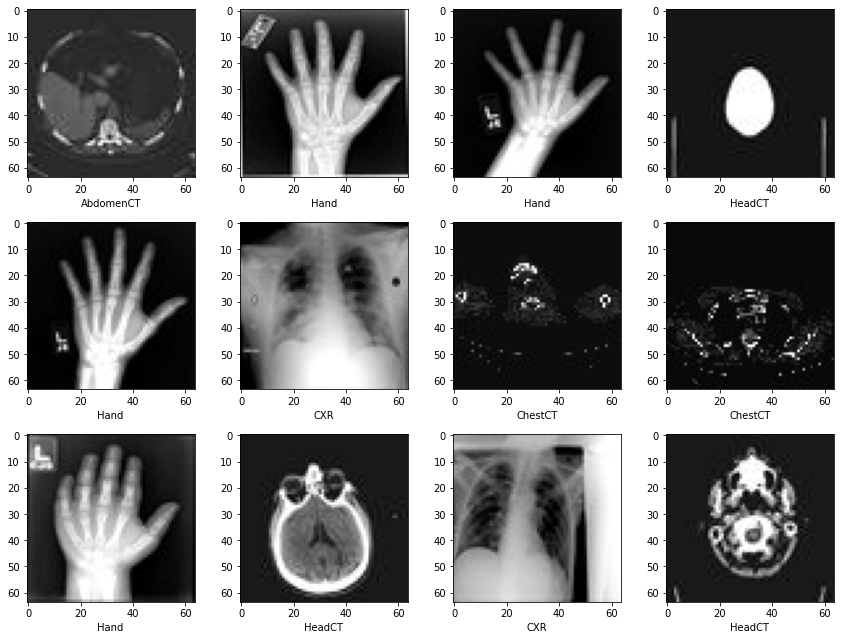

In [ ]:
plt.subplots(3, 4, figsize=(12, 9))
for i, k in enumerate(np.random.randint(num_total, size=12)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray")
plt.tight_layout()
plt.show()

# **Prepare training, validation and test data lists**

Randomly select 10% of the dataset as validation and 10% as test, ensuring to keep the same class balance across the train/val/test sets.



In [ ]:
val_frac = 0.1
test_frac = 0.1

all_indices_list = []
train_indices_list = []
val_indices_list = []
test_indices_list = []
start_num = 0
for i in range(num_class):
  if i == 0:
    start_num = 0
  else:
    start_num = num_each[i-1]+start_num
  #create unshuffled list of indices corresponding to this class
  indices = np.arange(start_num, num_each[i]+start_num)
  #randomly shuffle list
  np.random.shuffle(indices)
  all_indices_list.append(indices)
  #split this class into train/val/test
  val_split = int(val_frac * num_each[i])
  test_split = int(test_frac * num_each[i])
  val_indices_list.append(indices[:val_split])
  test_indices_list.append(indices[val_split:(test_split+val_split)])
  train_indices_list.append(indices[(test_split+val_split):])

#flatten out indices list
flattened_all_indices_list = [num for sublist in all_indices_list for num in sublist]
flattened_train_indices_list = [num for sublist in train_indices_list for num in sublist]
flattened_val_indices_list = [num for sublist in val_indices_list for num in sublist]
flattened_test_indices_list = [num for sublist in test_indices_list for num in sublist]
#make final train/val/test
train_x = [image_files_list[i] for i in flattened_train_indices_list]
train_y = [image_class[i] for i in flattened_train_indices_list]
val_x = [image_files_list[i] for i in flattened_val_indices_list]
val_y = [image_class[i] for i in flattened_val_indices_list]
test_x = [image_files_list[i] for i in flattened_test_indices_list]
test_y = [image_class[i] for i in flattened_test_indices_list]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)} \n")

class_names_list = []
for filename in test_x:
  class_name = os.path.split(os.path.split(filename)[0])[1]
  class_names_list.append(class_name)

print('Verify test set class balance')
unique_counts = np.unique(class_names_list, return_counts=True)
print(list(unique_counts[0]))
print(list(unique_counts[1]))

Training count: 47164, Validation count: 5895, Test count: 5895 

Verify test set class balance
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
[1000, 895, 1000, 1000, 1000, 1000]


# **Define MONAI transforms, Dataset and Dataloader to pre-process data**

Data augmentation can be a powerful method in improving the generalizability of neural networks. For this notebook, we will apply rotation, flipping, and zoom augmentations to the training set. No augmentations will be applied to the val or test sets.

In [ ]:
#randomly rotate, flip and zoom the training images by the given parameters
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x = np.pi/12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

#no augmentations for the validation set
val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_class)])

In [ ]:
#Simply dataloader that uses PyTorch Dataset
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

#Intsantiate the training/validation/testing data loaders with a given batch size and number of workers (which determines the amount of parallelism across CPU cores)
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=128, num_workers=2)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=128, num_workers=2)

Let's inspect different types of augmentations that we can apply using MONAI.

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


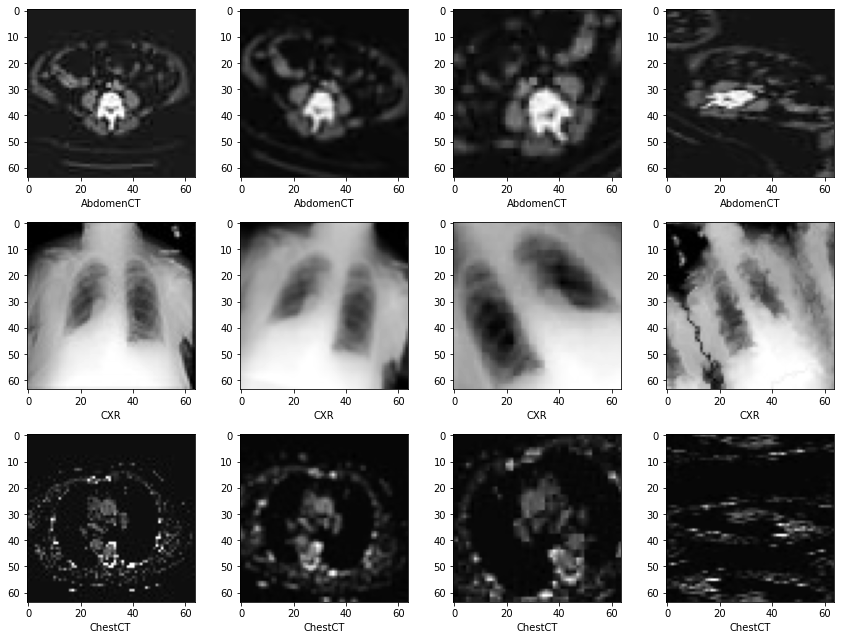

In [ ]:
#no spatial or intensity augmentations applied
transforms_none = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        EnsureType(),
    ]
)

#minimal augmentations applied in the form of rotating and zooming
transforms_light = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        Rotate(np.pi/12, keep_size=True),
        Zoom(1.1),
        EnsureType(),
    ]
)

#moderate augmentations applied in the form of rotating, flipping, and zooming
transforms_medium = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        Rotate(np.pi/6, keep_size=True),
        Flip(spatial_axis=0),
        Zoom(1.5),
        EnsureType(),
    ]
)

#extreme augmentations applied in the form of gaussian noise, scaling, flipping, and elastic deformations
transforms_high = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        RandGaussianNoise(prob=1, mean=0.0, std=0.1),
        ScaleIntensity(.8),
        Flip(spatial_axis=0),
        Rand2DElastic([2,2], [0,1], prob=1, rotate_range=[-np.pi/3,np.pi/3], shear_range=[-.2,.2], scale_range=[.5, 2.0]),
        EnsureType(),
    ]
)

#choose 3 example cases to view transforms
test_augmentations_x = [train_x[0],train_x[20000],train_x[31000]]
test_augmentations_y = [train_y[0],train_y[20000],train_y[31000]]
for batch_data_none in torch.utils.data.DataLoader(MedNISTDataset(test_augmentations_x, test_augmentations_y, transforms_none), batch_size=3, shuffle=False, num_workers=2):
  break

for batch_data_light in torch.utils.data.DataLoader(MedNISTDataset(test_augmentations_x, test_augmentations_y, transforms_light), batch_size=3, shuffle=False, num_workers=2):
  break

for batch_data_medium in torch.utils.data.DataLoader(MedNISTDataset(test_augmentations_x, test_augmentations_y, transforms_medium), batch_size=3, shuffle=False, num_workers=2):
  break

for batch_data_high in torch.utils.data.DataLoader(MedNISTDataset(test_augmentations_x, test_augmentations_y, transforms_high), batch_size=3, shuffle=False, num_workers=2):
  break

#plot 3 chosen example cases at the 4 different levels of augmentation
batch_data = [batch_data_none, batch_data_light, batch_data_medium, batch_data_high]
plt.subplots(3, 4, figsize=(12, 9))
for i, k in enumerate(np.arange(12)):
    arr = np.rot90(np.squeeze(batch_data[i%4][0][k//4,0,...]),3)
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[batch_data[i%4][1][k//4]])
    plt.imshow(arr, cmap="gray")
plt.tight_layout()
plt.show()

As we move across the columns, we can see the effects of the more extreme augmentations. Too little augmentation may not provide enough variance in imaging data, leading the model to overfit on the training set. Too much augmentation may lead to physiologically impossible looking images, thus polluting the training set with noisy data. Finding the right amount of data augmentation is a necessary step in the deep learning pipeline.

# **Define network and optimizer**

1) Set learning rate for how much the model is updated per batch.

2) Set total epoch number. Note that by shuffling the data at each epoch, we ensure that the order of the training data of every epoch is different. And as this is just a tutorial, we will only train for 2 epochs (since training for longer will be too time consuming for the purposes of this demostration). If we train for 5-10 epochs, the model will achieve 100% accuracy on test dataset.

3) Use a pre-configured DenseNet121 architecture from MONAI (which can support both 2D and 3D classification tasks). We will instantiate this architecutre on the GPU to ensure speedy network training.

4) Choose an optimizer. The two most popular optimizers are SGD (stochastic gradient descent) and ADAM (adaptive moment estimation). We will use ADAM today.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 2
val_interval = 1
auc_metric = ROCAUCMetric()

# **Model training**

Execute a typical PyTorch training loop. This will do the forward and backward passes of every batch in the epoch, and then check the validation accuracy. We will save the model weights to file only if the current model has the highest validation accuracy seen so far.

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/2
1/368, train_loss: 1.7914
2/368, train_loss: 1.7724
3/368, train_loss: 1.7810
4/368, train_loss: 1.7369
5/368, train_loss: 1.7231
6/368, train_loss: 1.7001
7/368, train_loss: 1.6724
8/368, train_loss: 1.6584
9/368, train_loss: 1.6475
10/368, train_loss: 1.6243
11/368, train_loss: 1.6077
12/368, train_loss: 1.5799
13/368, train_loss: 1.5708
14/368, train_loss: 1.5475
15/368, train_loss: 1.5233
16/368, train_loss: 1.5336
17/368, train_loss: 1.5004
18/368, train_loss: 1.4753
19/368, train_loss: 1.4501
20/368, train_loss: 1.4233
21/368, train_loss: 1.4416
22/368, train_loss: 1.3898
23/368, train_loss: 1.4140
24/368, train_loss: 1.3645
25/368, train_loss: 1.3475
26/368, train_loss: 1.3358
27/368, train_loss: 1.3423
28/368, train_loss: 1.3007
29/368, train_loss: 1.2839
30/368, train_loss: 1.2987
31/368, train_loss: 1.2484
32/368, train_loss: 1.2633
33/368, train_loss: 1.2122
34/368, train_loss: 1.2603
35/368, train_loss: 1.1840
36/368, train_loss: 1.1613
37/368, train_lo

# **Plot the loss and metric**

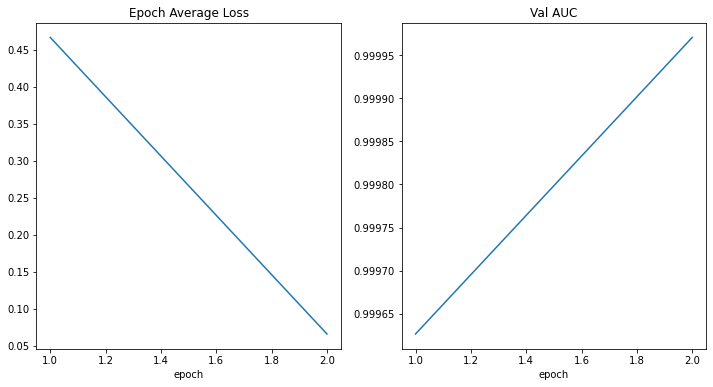

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

As we can see, the loss curve is going down (and the validation AUC curve is going up), implying that we still need to train for longer. As noted in the beginning, we can achieve perfect validation/testing accuracy if we train for long enough. We limit to 2 epochs in the interest of time.

# **Evaluate the model on test dataset**

After training and validation, we saved the model which performed best on the validation set. We need to evaluate the model on test dataset to check whether it's robust and not over-fitting. We'll use these predictions to generate a classification report.

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9900    0.9860    0.9880      1000
   BreastMRI     0.9989    0.9877    0.9933       895
         CXR     1.0000    0.9960    0.9980      1000
     ChestCT     0.9960    1.0000    0.9980      1000
        Hand     0.9960    0.9970    0.9965      1000
      HeadCT     0.9862    0.9990    0.9925      1000

    accuracy                         0.9944      5895
   macro avg     0.9945    0.9943    0.9944      5895
weighted avg     0.9944    0.9944    0.9944      5895



We will show 12 images from the test set that the network incorrectly classified.

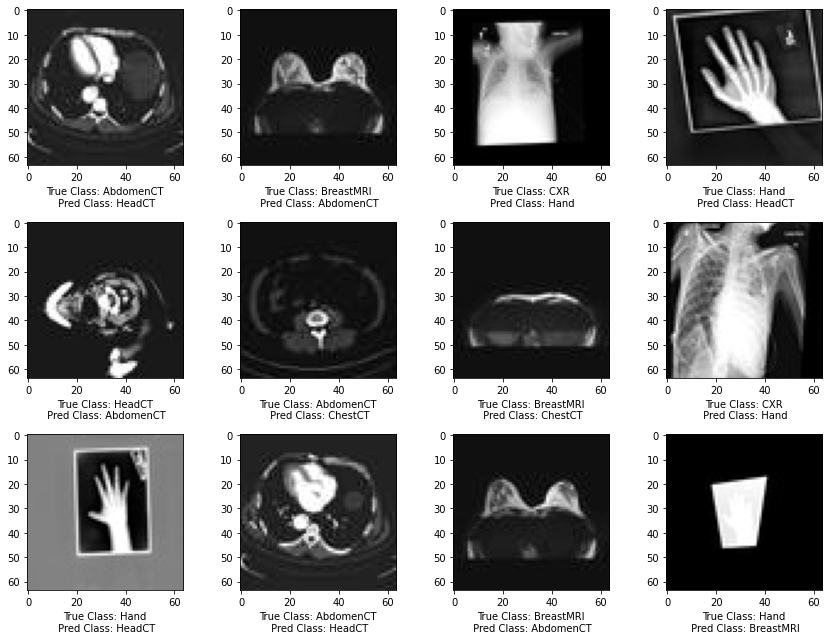

In [ ]:
#To ensure that we see all classes, we will re-order the set of mistakes to maximize the number of different classes
idx_wrong = np.where(np.array(y_true) != np.array(y_pred))
test_y_wrong = list(np.array(test_y)[idx_wrong])

test_y_wrong_reordered = []
idx_wrong_reordered = []
test_y_wrong_copy = deepcopy(test_y_wrong)
counter = 0
list_complete = False
while list_complete == False:
  temp_idx = np.where(test_y_wrong_copy == (counter % num_class))
  if (counter % num_class) in test_y_wrong_copy:
    temp_idx = test_y_wrong_copy.index(counter % num_class)
    idx_wrong_reordered.append(temp_idx + len(test_y_wrong_reordered))
    test_y_wrong_reordered.append(test_y_wrong_copy.pop(temp_idx))
  if len(idx_wrong_reordered) == 12:
    list_complete = True
  if len(test_y_wrong_copy) == 0:
    list_complete = True
  counter = counter + 1

test_x_wrong_reordered = list(np.array(test_x)[idx_wrong[0][idx_wrong_reordered]])
test_y_wrong_reordered = list(np.array(test_y)[idx_wrong[0][idx_wrong_reordered]])

for batch_data in torch.utils.data.DataLoader(MedNISTDataset(test_x_wrong_reordered, test_y_wrong_reordered, val_transforms), batch_size=min(len(test_x_wrong), 12), shuffle=False, num_workers=2):
  break

if batch_data[0].shape[0] < 12:
    batch_data[0] = np.pad(batch_data[0], ((0, 12 - batch_data[0].shape[0]), (0, 0), (0, 0), (0, 0)))
    batch_data[1] = np.pad(batch_data[1], (0, 12 - batch_data[1].shape[0]), mode='constant', constant_values=-1)

plt.subplots(3, 4, figsize=(12, 9))
for i, k in enumerate(np.arange(12)):
    arr = np.rot90(np.squeeze(batch_data[0][k,0,...]),3)
    plt.subplot(3, 4, i + 1)
    if batch_data[1][k] != -1:
      plt.xlabel('True Class: ' + class_names[batch_data[1][k]] + '\n Pred Class: ' + class_names[np.array(y_pred)[idx_wrong[0][idx_wrong_reordered]][k]])
    else:
      plt.xlabel("")
    plt.imshow(arr, cmap="gray")
plt.tight_layout()
plt.show()

The above plot shows mistakes by the model. You can see what the true class and predicted class was for each image. As we train the model for longer periods of time, the total number of mistakes will shrink to zero (since this is a relatively easy task. For real-world problems, we will almost always expect to see some mistakes.